In [1]:
import random
import gc

import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np

import fastai.vision.all as fv

from Layers import num_params, Normalize

In [2]:
path = fv.untar_data(fv.URLs.CAMVID)

In [3]:
path.ls()

(#4) [Path('/home/emacc/.fastai/data/camvid/labels'),Path('/home/emacc/.fastai/data/camvid/codes.txt'),Path('/home/emacc/.fastai/data/camvid/valid.txt'),Path('/home/emacc/.fastai/data/camvid/images')]

In [4]:
lbl_path, codes_txt, valid_txt, images= path.ls()

In [5]:
images

Path('/home/emacc/.fastai/data/camvid/images')

In [6]:
images.ls()

(#702) [Path('/home/emacc/.fastai/data/camvid/images/0016E5_04500.png'),Path('/home/emacc/.fastai/data/camvid/images/0016E5_07971.png'),Path('/home/emacc/.fastai/data/camvid/images/Seq05VD_f01740.png'),Path('/home/emacc/.fastai/data/camvid/images/Seq05VD_f01920.png'),Path('/home/emacc/.fastai/data/camvid/images/Seq05VD_f03390.png'),Path('/home/emacc/.fastai/data/camvid/images/0006R0_f03630.png'),Path('/home/emacc/.fastai/data/camvid/images/0001TP_006720.png'),Path('/home/emacc/.fastai/data/camvid/images/0001TP_007470.png'),Path('/home/emacc/.fastai/data/camvid/images/Seq05VD_f04740.png'),Path('/home/emacc/.fastai/data/camvid/images/Seq05VD_f01980.png')...]

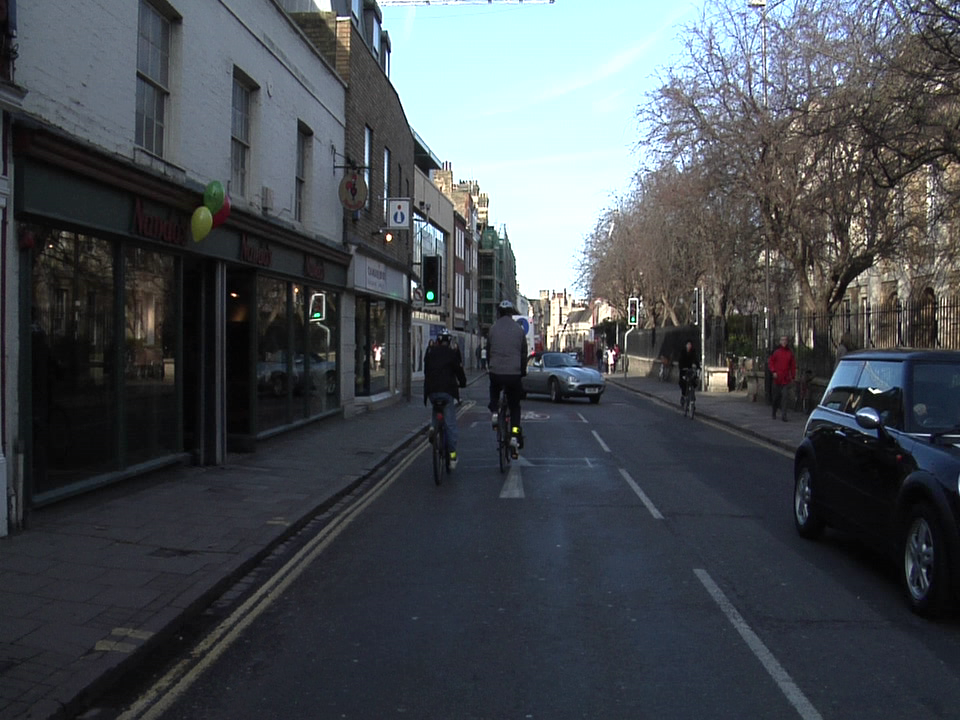

In [7]:
im = images.ls()[1]
fv.PILImage.create(im)

In [8]:
lbl_path.ls()

(#701) [Path('/home/emacc/.fastai/data/camvid/labels/0016E5_08065_P.png'),Path('/home/emacc/.fastai/data/camvid/labels/0016E5_08280_P.png'),Path('/home/emacc/.fastai/data/camvid/labels/0016E5_01080_P.png'),Path('/home/emacc/.fastai/data/camvid/labels/0016E5_08125_P.png'),Path('/home/emacc/.fastai/data/camvid/labels/0016E5_08113_P.png'),Path('/home/emacc/.fastai/data/camvid/labels/0001TP_006720_P.png'),Path('/home/emacc/.fastai/data/camvid/labels/0016E5_07987_P.png'),Path('/home/emacc/.fastai/data/camvid/labels/Seq05VD_f02850_P.png'),Path('/home/emacc/.fastai/data/camvid/labels/0016E5_07620_P.png'),Path('/home/emacc/.fastai/data/camvid/labels/0001TP_009030_P.png')...]

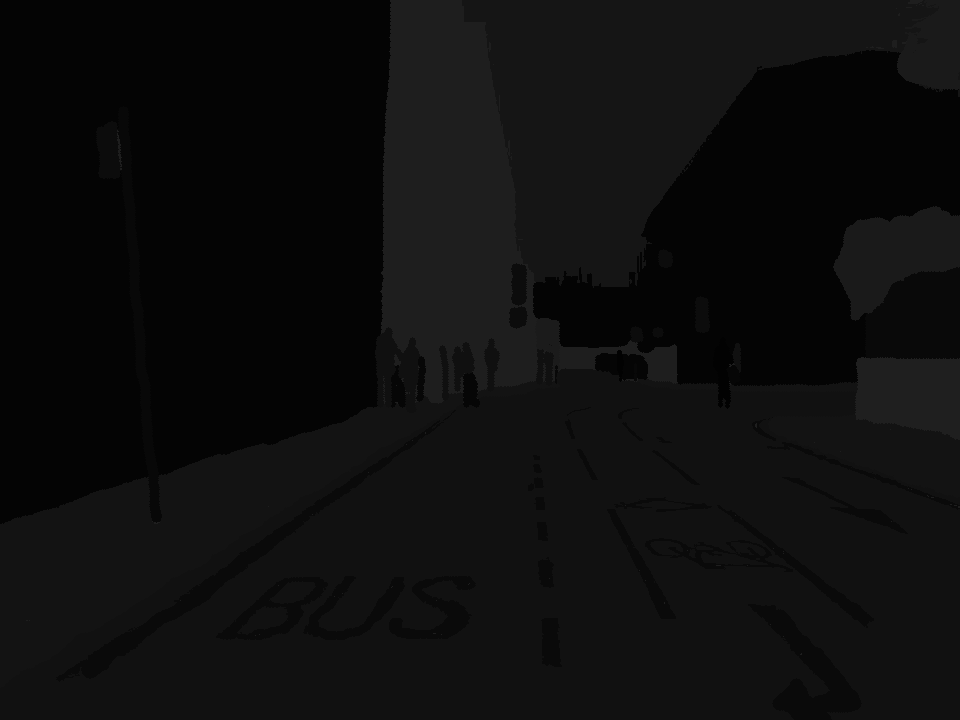

In [9]:
lbl = lbl_path.ls()[1]
fv.PILImage.create(lbl)

In [10]:
def img2label(img):
    return lbl_path/f"{img.stem}_P.png"

In [11]:
img2label(images.ls()[0])

Path('/home/emacc/.fastai/data/camvid/labels/0016E5_04500_P.png')

In [12]:
img2label(images.ls()[0]).exists()

True

In [13]:
valid_set = set(np.loadtxt(valid_txt,dtype='str'))

In [14]:
valid_set

{'0016E5_07959.png',
 '0016E5_07961.png',
 '0016E5_07963.png',
 '0016E5_07965.png',
 '0016E5_07967.png',
 '0016E5_07969.png',
 '0016E5_07971.png',
 '0016E5_07973.png',
 '0016E5_07975.png',
 '0016E5_07977.png',
 '0016E5_07979.png',
 '0016E5_07981.png',
 '0016E5_07983.png',
 '0016E5_07985.png',
 '0016E5_07987.png',
 '0016E5_07989.png',
 '0016E5_07991.png',
 '0016E5_07993.png',
 '0016E5_07995.png',
 '0016E5_07997.png',
 '0016E5_07999.png',
 '0016E5_08001.png',
 '0016E5_08003.png',
 '0016E5_08005.png',
 '0016E5_08007.png',
 '0016E5_08009.png',
 '0016E5_08011.png',
 '0016E5_08013.png',
 '0016E5_08015.png',
 '0016E5_08017.png',
 '0016E5_08019.png',
 '0016E5_08021.png',
 '0016E5_08023.png',
 '0016E5_08025.png',
 '0016E5_08027.png',
 '0016E5_08029.png',
 '0016E5_08031.png',
 '0016E5_08033.png',
 '0016E5_08035.png',
 '0016E5_08037.png',
 '0016E5_08039.png',
 '0016E5_08041.png',
 '0016E5_08043.png',
 '0016E5_08045.png',
 '0016E5_08047.png',
 '0016E5_08049.png',
 '0016E5_08051.png',
 '0016E5_0805

In [15]:
!cat {codes_txt}

Animal
Archway
Bicyclist
Bridge
Building
Car
CartLuggagePram
Child
Column_Pole
Fence
LaneMkgsDriv
LaneMkgsNonDriv
Misc_Text
MotorcycleScooter
OtherMoving
ParkingBlock
Pedestrian
Road
RoadShoulder
Sidewalk
SignSymbol
Sky
SUVPickupTruck
TrafficCone
TrafficLight
Train
Tree
Truck_Bus
Tunnel
VegetationMisc
Void
Wall


In [14]:
codes = np.loadtxt(codes_txt, dtype='str')

In [15]:
def load_data(folder, img_size, batch_size):
    tfms = fv.aug_transforms(size = img_size)
    
    data = fv.DataBlock(blocks     = (fv.ImageBlock, fv.MaskBlock(codes = codes)),
                        get_items  = fv.get_image_files,
                        get_y      = img2label,
                        splitter   = fv.FuncSplitter(lambda x: x.name in valid_set),
                        item_tfms  = fv.Resize(int(1.5*img_size)),
                        batch_tfms = tfms,
                       )
    return data.dataloaders(folder, bs = batch_size)

In [16]:
data = load_data(images, 224,32)

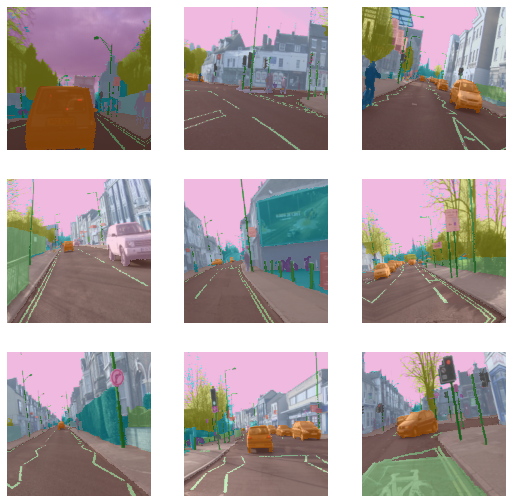

In [17]:
data.show_batch()

In [22]:
model = nn.Sequential(
    nn.Conv2d(3,16, kernel_size = 3, padding = 1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16,16,kernel_size = 3, padding = 1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16,16,kernel_size = 3, padding = 1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16,16,kernel_size = 3, padding = 1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16,32, kernel_size = 3, padding = 1)
).cuda()

In [18]:
def seg_accuracy(yp, y):
    y = fv.cast(y, fv.Tensor)
    correct = (yp.argmax(dim=1) == y)
    return correct.float().mean()

In [24]:
x,y = data.one_batch()

In [25]:
x.shape

(32, 3, 224, 224)

In [26]:
y.shape

(32, 224, 224)

In [27]:
yp = model(x)

In [28]:
yp.shape

(32, 32, 224, 224)

In [30]:
yp.argmax(dim=1) == y

TensorImage([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False,  True],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False,  True, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
     

In [31]:
yp.argmax(dim=1) == fv.cast(y,fv.Tensor)

TensorImage([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False,  True],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False,  True, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
     

In [35]:
np.allclose((yp.argmax(dim=1) == fv.cast(y,fv.Tensor)).cpu(), (yp.argmax(dim=1) == y).cpu())

True

In [36]:
learn = fv.Learner(data, model, opt_func = fv .ranger, metrics = seg_accuracy)

In [37]:
learn.summary()

Sequential (Input shape: 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 16 x 224 x 224 
Conv2d                                    448        True      
BatchNorm2d                               32         True      
ReLU                                                           
Conv2d                                    2320       True      
BatchNorm2d                               32         True      
ReLU                                                           
Conv2d                                    2320       True      
BatchNorm2d                               32         True      
ReLU                                                           
Conv2d                                    2320       True      
BatchNorm2d                               32         True      
ReLU                                                           
____________________________________________________________________________
                    

SuggestedLRs(lr_min=0.2290867567062378, lr_steep=0.04786301031708717)

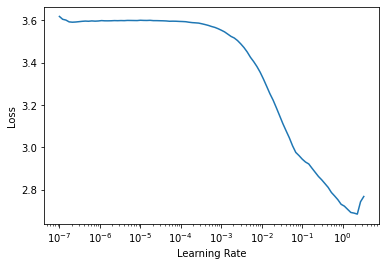

In [38]:
learn.lr_find()

In [39]:
learn.fit_one_cycle(20, 1e-2, div =1, pct_start = 0.7)

epoch,train_loss,valid_loss,seg_accuracy,time
0,2.935577,2.933436,0.426457,00:06
1,2.304805,2.223224,0.434093,00:05
2,1.920818,1.944882,0.470332,00:05
3,1.694702,1.540077,0.538565,00:05
4,1.552659,1.411382,0.580912,00:06
5,1.446482,1.484420,0.577723,00:06
6,1.381758,1.471352,0.580141,00:06
7,1.331355,1.370440,0.581741,00:06
8,1.284130,1.554897,0.553092,00:06
9,1.265127,1.531956,0.544283,00:06


In [19]:
data.train.bs = 16
data.valid.bs = 16

In [20]:
learn = fv.unet_learner(data, fv.resnet18, normalize = False, opt_func = fv.ranger, metrics =seg_accuracy)

In [24]:
learn.summary()

DynamicUnet (Input shape: 16)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                     

In [21]:
gc.collect()

20067

In [22]:
torch.cuda.empty_cache()

SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=0.0008317637839354575)

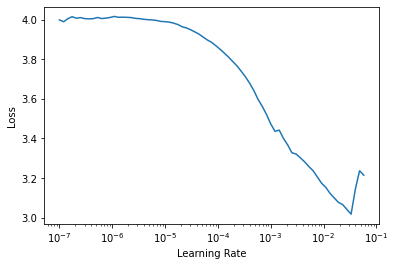

In [23]:
learn.lr_find()

In [25]:
learn.fit_one_cycle(20,1e-3, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,seg_accuracy,time
0,2.150090,1.406432,0.630769,00:16
1,1.397929,0.825519,0.802499,00:16
2,1.041209,0.683393,0.822871,00:16
3,0.854028,0.653755,0.830483,00:16
4,0.727510,0.603505,0.829654,00:16
5,0.654813,0.531340,0.846126,00:16
6,0.607582,0.557120,0.842060,00:15
7,0.568654,0.556614,0.830358,00:15
8,0.532452,0.477663,0.850687,00:15
9,0.535773,0.482877,0.847689,00:15
